<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_04_imbalanced_data_SMOTEENN_ADASYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
import torch
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, SklearnSimpleNN, train_model


### Load and Preprocess the Data



In [9]:
# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Convert test data to tensors
X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)


### Function Definitions

In [10]:
# Function to apply SMOTEENN
def apply_smoteenn(X_train, y_train):
    smoteenn = SMOTEENN(random_state=42)
    X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply ADASYN
def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to evaluate the model
def evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, pos_weight=1.0):
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()
    return y_prob


### Evaluate No Resampling

In [11]:
# Train model with the best class weights (3.0) without resampling
best_class_weight = 3.0
X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
y_prob_no_resampling = evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, pos_weight=best_class_weight)

# Use the best lower threshold (0.10) to predict final labels
best_lower_threshold = 0.10
y_pred_no_resampling = (y_prob_no_resampling > best_lower_threshold).astype(int)

# Evaluate and print final performance
report_no_resampling = classification_report(y_test_tensor.numpy(), y_pred_no_resampling, output_dict=True)
print(f"Final Model Performance without Resampling at Best Lower Threshold {best_lower_threshold}:\n")
print(classification_report(y_test_tensor.numpy(), y_pred_no_resampling))


Final Model Performance without Resampling at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77      4673
         1.0       0.36      0.58      0.44      1327

    accuracy                           0.68      6000
   macro avg       0.61      0.64      0.61      6000
weighted avg       0.75      0.68      0.70      6000



### Apply SMOTEENN

In [12]:
# Apply SMOTEENN
X_train_smoteenn, y_train_smoteenn = apply_smoteenn(X_train, y_train)
X_train_tensor_smoteenn, y_train_tensor_smoteenn = convert_to_tensors(X_train_smoteenn, y_train_smoteenn)

# Evaluate SMOTEENN
y_prob_smoteenn = evaluate_model(X_train_tensor_smoteenn, y_train_tensor_smoteenn, X_test_tensor, y_test_tensor, pos_weight=best_class_weight)
y_pred_smoteenn = (y_prob_smoteenn > best_lower_threshold).astype(int)
report_smoteenn = classification_report(y_test_tensor.numpy(), y_pred_smoteenn, output_dict=True)
print(f"Final Model Performance with SMOTEENN at Best Lower Threshold {best_lower_threshold}:\n")
print(classification_report(y_test_tensor.numpy(), y_pred_smoteenn))


Final Model Performance with SMOTEENN at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.88      0.47      0.62      4673
         1.0       0.30      0.78      0.43      1327

    accuracy                           0.54      6000
   macro avg       0.59      0.63      0.52      6000
weighted avg       0.75      0.54      0.58      6000



### Apply ADASYN

In [13]:
# Apply ADASYN
X_train_adasyn, y_train_adasyn = apply_adasyn(X_train, y_train)
X_train_tensor_adasyn, y_train_tensor_adasyn = convert_to_tensors(X_train_adasyn, y_train_adasyn)

# Evaluate ADASYN
y_prob_adasyn = evaluate_model(X_train_tensor_adasyn, y_train_tensor_adasyn, X_test_tensor, y_test_tensor, pos_weight=best_class_weight)
y_pred_adasyn = (y_prob_adasyn > best_lower_threshold).astype(int)
report_adasyn = classification_report(y_test_tensor.numpy(), y_pred_adasyn, output_dict=True)
print(f"Final Model Performance with ADASYN at Best Lower Threshold {best_lower_threshold}:\n")
print(classification_report(y_test_tensor.numpy(), y_pred_adasyn))


Final Model Performance with ADASYN at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.90      0.14      0.24      4673
         1.0       0.24      0.94      0.38      1327

    accuracy                           0.32      6000
   macro avg       0.57      0.54      0.31      6000
weighted avg       0.75      0.32      0.27      6000



### Compare Results

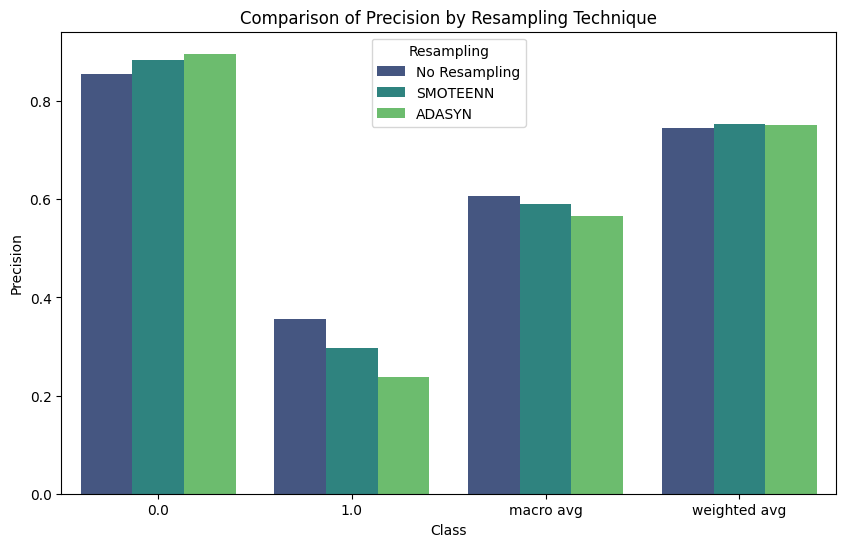

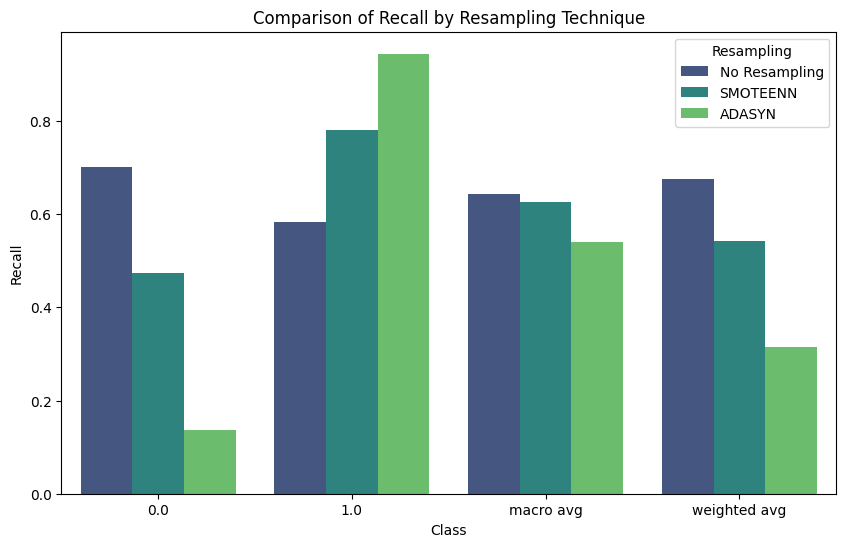

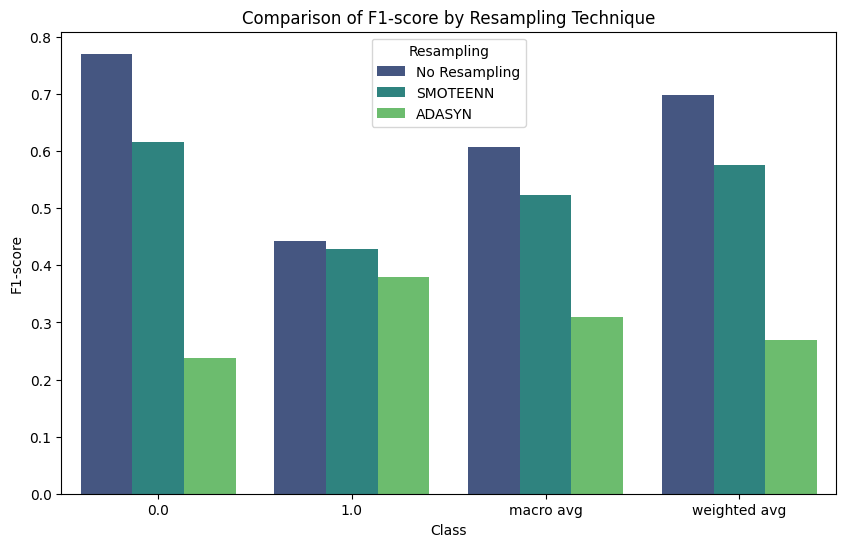

In [14]:
# Convert reports to DataFrames
df_no_resampling = pd.DataFrame(report_no_resampling).transpose()
df_smoteenn = pd.DataFrame(report_smoteenn).transpose()
df_adasyn = pd.DataFrame(report_adasyn).transpose()

# Add a column to identify the resampling technique
df_no_resampling['resampling'] = 'No Resampling'
df_smoteenn['resampling'] = 'SMOTEENN'
df_adasyn['resampling'] = 'ADASYN'

# Concatenate all DataFrames
df_comparison = pd.concat([df_no_resampling, df_smoteenn, df_adasyn])

# Filter to relevant metrics
metrics = ['precision', 'recall', 'f1-score']
df_comparison = df_comparison[df_comparison.index.isin(['0.0', '1.0', 'macro avg', 'weighted avg'])][metrics + ['resampling']]

# Reset index for easier plotting
df_comparison.reset_index(inplace=True)

# Plot the comparison
def plot_comparison(df, metric):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='index', y=metric, hue='resampling', palette='viridis')
    plt.title(f'Comparison of {metric.capitalize()} by Resampling Technique')
    plt.xlabel('Class')
    plt.ylabel(metric.capitalize())
    plt.legend(title='Resampling')
    plt.show()

# Plot precision, recall, and f1-score comparisons
for metric in metrics:
    plot_comparison(df_comparison, metric)
